In [149]:
import numpy as np
import pandas as pd
from functions import *

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost as xgb

from sklearn.metrics import plot_confusion_matrix, classification_report,accuracy_score, f1_score

# Scalers
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler

# Categorical Create Dummies
from sklearn.preprocessing import OneHotEncoder

In [2]:
#notes for later:
#drop NA values across the board
#investigate object types
#investigate kepid vs kepoi_name

#disposition uses lightcurve data to finalize candidates into confirmed status
#remove other metrics already used to classify dispositions

In [3]:
# REMOVE - USED TO DETERMINE CLASSIFIERS
# koi_score
# koi_max_mult_ev
# flags?

In [4]:
# Kepler uses transit data to determine potential exo planets, further analysis is to finalize candidates
# plan of action - find thats related to transit data, remove the secondary tests done once a possible candidate is identified

# The Introduction

# EDA

In [5]:
df = pd.read_csv(r'Data\KeplerData.csv',skiprows=76)

In [6]:
import random
random.seed(45)

## Info Describe and Plots of Distributions

In [7]:
df.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-0.021,-0.038,0.00070,0.00060,-0.025,-0.034,0.042,0.002,-0.027,0.027
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 70 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepid              9564 non-null   int64  
 1   kepoi_name         9564 non-null   object 
 2   kepler_name        2365 non-null   object 
 3   koi_disposition    9564 non-null   object 
 4   koi_pdisposition   9564 non-null   object 
 5   koi_score          8054 non-null   float64
 6   koi_fpflag_nt      9564 non-null   int64  
 7   koi_fpflag_ss      9564 non-null   int64  
 8   koi_fpflag_co      9564 non-null   int64  
 9   koi_fpflag_ec      9564 non-null   int64  
 10  koi_disp_prov      9564 non-null   object 
 11  koi_period         9564 non-null   float64
 12  koi_time0bk        9564 non-null   float64
 13  koi_time0          9564 non-null   float64
 14  koi_eccen          9201 non-null   float64
 15  koi_longp          0 non-null      float64
 16  koi_impact         9201 

In [9]:
df.describe()

,kepid,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_time0,koi_eccen,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
count,9.564000e+03,8054.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9.564000e+03,9201.0,...,9109.000000,9109.000000,8734.000000,8747.000000,8965.000000,8965.000000,8965.000000,8994.000000,8994.000000,8994.000000
mean,7.690628e+06,0.480829,0.208595,0.232748,0.197512,0.120033,75.671358,166.183251,2.454999e+06,0.0,...,-0.316136,-0.165817,-0.000097,-0.000714,-0.012281,-0.045420,1.866561,-0.024244,-0.076749,1.812566
std,2.653459e+06,0.476928,4.767290,0.422605,0.398142,0.325018,1334.744046,67.918960,6.791896e+01,0.0,...,20.254777,20.534655,0.058225,0.092987,2.406550,2.573558,2.988742,2.382286,2.553758,2.986376
min,7.574500e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.241843,120.515914,2.454954e+06,0.0,...,-742.430000,-417.900000,-4.000000,-6.000000,-25.100000,-75.900000,0.000000,-27.800000,-76.600000,0.000000
25%,5.556034e+06,0.000000,0.000000,0.000000,0.000000,0.000000,2.733684,132.761718,2.454966e+06,0.0,...,-0.600000,-0.680000,-0.000210,-0.000220,-0.320000,-0.387000,0.170000,-0.310000,-0.390000,0.210000
50%,7.906892e+06,0.334000,0.000000,0.000000,0.000000,0.000000,9.752831,137.224595,2.454970e+06,0.0,...,-0.000500,-0.034000,0.000000,0.000000,0.000000,0.000000,0.610000,-0.004000,-0.017000,0.583000
75%,9.873066e+06,0.998000,0.000000,0.000000,0.000000,0.000000,40.715178,170.694603,2.455004e+06,0.0,...,0.570000,0.500000,0.000240,0.000240,0.309000,0.300000,2.160000,0.290000,0.300000,1.970000
max,1.293514e+07,1.000000,465.000000,1.000000,1.000000,1.000000,129995.778400,1472.522306,2.456306e+06,0.0,...,549.500000,712.500000,1.190000,5.000000,45.680000,27.500000,88.600000,46.570000,34.000000,89.600000


In [10]:
df.koi_pdisposition.value_counts()

FALSE POSITIVE    4847
CANDIDATE         4717
Name: koi_pdisposition, dtype: int64

In [11]:
(df.koi_disposition == df.koi_pdisposition).value_counts()

True     7200
False    2364
dtype: int64

In [12]:
df_FP = df.loc[df.koi_disposition == "FALSE POSITIVE"]

In [13]:
(df_FP.koi_disposition == df_FP.koi_pdisposition).value_counts()

True     4839
False       1
dtype: int64

In [14]:
for col in df.columns:
    print(df[col].isna().value_counts())

False    9564
Name: kepid, dtype: int64
False    9564
Name: kepoi_name, dtype: int64
True     7199
False    2365
Name: kepler_name, dtype: int64
False    9564
Name: koi_disposition, dtype: int64
False    9564
Name: koi_pdisposition, dtype: int64
False    8054
True     1510
Name: koi_score, dtype: int64
False    9564
Name: koi_fpflag_nt, dtype: int64
False    9564
Name: koi_fpflag_ss, dtype: int64
False    9564
Name: koi_fpflag_co, dtype: int64
False    9564
Name: koi_fpflag_ec, dtype: int64
False    9564
Name: koi_disp_prov, dtype: int64
False    9564
Name: koi_period, dtype: int64
False    9564
Name: koi_time0bk, dtype: int64
False    9564
Name: koi_time0, dtype: int64
False    9201
True      363
Name: koi_eccen, dtype: int64
True    9564
Name: koi_longp, dtype: int64
False    9201
True      363
Name: koi_impact, dtype: int64
False    9564
Name: koi_duration, dtype: int64
True    9564
Name: koi_ingress, dtype: int64
False    9201
True      363
Name: koi_depth, dtype: int64
False    92

## Drop obvious columns (ID etc) and rows of missing data

### Initial Column Drop

In [15]:
len(df.columns)

70

In [16]:
df.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-0.021,-0.038,0.00070,0.00060,-0.025,-0.034,0.042,0.002,-0.027,0.027
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070


In [17]:
drop_initial = ['kepid','kepler_name','koi_ingress','koi_longp','koi_sage'] #'kepoi_name' will be dropped for model

In [18]:
df_initial_drop = df.drop(drop_initial,axis=1)

In [19]:
df_initial_drop.head()

,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_disp_prov,koi_period,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,q1_q17_dr25_sup_koi,9.488036,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,q1_q17_dr25_sup_koi,54.418383,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,K00753.01,CANDIDATE,CANDIDATE,0.000,0,0,0,0,q1_q17_dr25_sup_koi,19.899140,...,-0.021,-0.038,0.00070,0.00060,-0.025,-0.034,0.042,0.002,-0.027,0.027
3,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,q1_q17_dr25_sup_koi,1.736952,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
4,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,q1_q17_dr25_sup_koi,2.525592,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070


### Drop rows of missing data

In [20]:
for col in df_initial_drop.columns:
    print(df_initial_drop[col].isna().value_counts())

False    9564
Name: kepoi_name, dtype: int64
False    9564
Name: koi_disposition, dtype: int64
False    9564
Name: koi_pdisposition, dtype: int64
False    8054
True     1510
Name: koi_score, dtype: int64
False    9564
Name: koi_fpflag_nt, dtype: int64
False    9564
Name: koi_fpflag_ss, dtype: int64
False    9564
Name: koi_fpflag_co, dtype: int64
False    9564
Name: koi_fpflag_ec, dtype: int64
False    9564
Name: koi_disp_prov, dtype: int64
False    9564
Name: koi_period, dtype: int64
False    9564
Name: koi_time0bk, dtype: int64
False    9564
Name: koi_time0, dtype: int64
False    9201
True      363
Name: koi_eccen, dtype: int64
False    9201
True      363
Name: koi_impact, dtype: int64
False    9564
Name: koi_duration, dtype: int64
False    9201
True      363
Name: koi_depth, dtype: int64
False    9201
True      363
Name: koi_ror, dtype: int64
False    9243
True      321
Name: koi_srho, dtype: int64
False    9564
Name: koi_fittype, dtype: int64
False    9201
True      363
Name: koi_pr

In [21]:
df_initial_drop = df_initial_drop.dropna(subset=['koi_score','koi_quarters','koi_fwm_stat_sig','koi_dicco_mra','koi_model_snr','koi_zmag','koi_fwm_sra','koi_smet','koi_gmag','koi_rmag','koi_imag'], how='any')

In [22]:
for col in df_initial_drop.columns:
    print(df_initial_drop[col].isna().value_counts())

False    6682
Name: kepoi_name, dtype: int64
False    6682
Name: koi_disposition, dtype: int64
False    6682
Name: koi_pdisposition, dtype: int64
False    6682
Name: koi_score, dtype: int64
False    6682
Name: koi_fpflag_nt, dtype: int64
False    6682
Name: koi_fpflag_ss, dtype: int64
False    6682
Name: koi_fpflag_co, dtype: int64
False    6682
Name: koi_fpflag_ec, dtype: int64
False    6682
Name: koi_disp_prov, dtype: int64
False    6682
Name: koi_period, dtype: int64
False    6682
Name: koi_time0bk, dtype: int64
False    6682
Name: koi_time0, dtype: int64
False    6682
Name: koi_eccen, dtype: int64
False    6682
Name: koi_impact, dtype: int64
False    6682
Name: koi_duration, dtype: int64
False    6682
Name: koi_depth, dtype: int64
False    6682
Name: koi_ror, dtype: int64
False    6682
Name: koi_srho, dtype: int64
False    6682
Name: koi_fittype, dtype: int64
False    6682
Name: koi_prad, dtype: int64
False    6682
Name: koi_sma, dtype: int64
False    6682
Name: koi_incl, dtype: in

In [23]:
len(df_initial_drop.columns)

65

In [24]:
# fig, axes = plt.subplots(figsize=(15,50),nrows=23,ncols=3)
# for i in range(len(df_initial_drop.columns)):
#     row = i%3
#     col = i//3
#     axis = axes[col,row]
#     axis.hist(df_initial_drop[df_initial_drop.columns[i]])
#     axis.set_title(df_initial_drop.columns[i])
#     axis.set_xlabel(df_initial_drop.columns[i])
#     axis.set_ylabel("Frequency")
#     plt.tight_layout()

In [25]:
add_drops = ['koi_sparprov','koi_trans_mod','koi_tce_delivname','koi_limbdark_mod','koi_fittype','koi_disp_prov']
df_initial_drop = df_initial_drop.drop(add_drops,axis=1)

In [26]:
# fig, axes = plt.subplots(figsize=(15,50),nrows=20,ncols=3)
# for i in range(len(df_initial_drop.columns)):
#     row = i%3
#     col = i//3
#     axis = axes[col,row]
#     axis.hist(df_initial_drop[df_initial_drop.columns[i]])
#     axis.set_title(df_initial_drop.columns[i])
#     axis.set_xlabel(df_initial_drop.columns[i])
#     axis.set_ylabel("Frequency")
#     plt.tight_layout()

In [27]:
df_initial_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6682 entries, 0 to 9563
Data columns (total 59 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   kepoi_name        6682 non-null   object 
 1   koi_disposition   6682 non-null   object 
 2   koi_pdisposition  6682 non-null   object 
 3   koi_score         6682 non-null   float64
 4   koi_fpflag_nt     6682 non-null   int64  
 5   koi_fpflag_ss     6682 non-null   int64  
 6   koi_fpflag_co     6682 non-null   int64  
 7   koi_fpflag_ec     6682 non-null   int64  
 8   koi_period        6682 non-null   float64
 9   koi_time0bk       6682 non-null   float64
 10  koi_time0         6682 non-null   float64
 11  koi_eccen         6682 non-null   float64
 12  koi_impact        6682 non-null   float64
 13  koi_duration      6682 non-null   float64
 14  koi_depth         6682 non-null   float64
 15  koi_ror           6682 non-null   float64
 16  koi_srho          6682 non-null   float64


# Build initial model with pipeline and log regression

In [28]:
candidates_df = df_initial_drop.loc[df_initial_drop['koi_disposition'] == 'CANDIDATE']
df_processed = df_initial_drop.loc[df_initial_drop['koi_disposition'] != 'CANDIDATE']

## Train Test Data

In [29]:
X = df_processed.drop(['koi_disposition','koi_pdisposition','kepoi_name'],axis=1)
y = df_processed['koi_disposition']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Initial Pipleline Model

In [31]:
initial_pipeline = Pipeline([('ss', StandardScaler()),
                            ('log',LogisticRegression())])

********************************************************

     Classification Report: Train

                precision    recall  f1-score   support

     CONFIRMED       0.99      0.99      0.99      1733
FALSE POSITIVE       0.99      0.99      0.99      2341

      accuracy                           0.99      4074
     macro avg       0.99      0.99      0.99      4074
  weighted avg       0.99      0.99      0.99      4074

********************************************************

     Classification Report: Test

                precision    recall  f1-score   support

     CONFIRMED       0.98      0.99      0.99       422
FALSE POSITIVE       0.99      0.99      0.99       597

      accuracy                           0.99      1019
     macro avg       0.99      0.99      0.99      1019
  weighted avg       0.99      0.99      0.99      1019

********************************************************



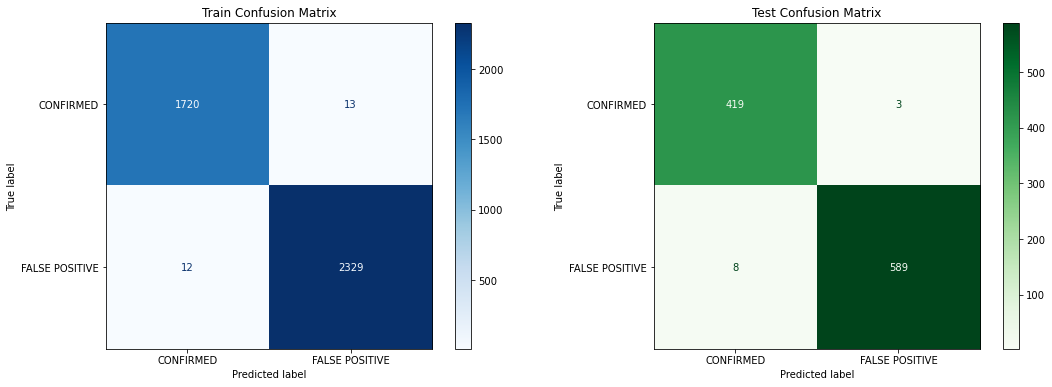

In [32]:
initial_model = run_class_model(initial_pipeline, X_train, y_train, X_test, y_test)

### Initial Findings/Results

* Performs well for an initial model, primarily looking for accuracy
* Model is able to predict False Positives too well.  After further investigation, there are columns included in the model
  which are already used to calculate the disposition (target variable) and should be removed

In [33]:
df_processed.head()

,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,170.538750,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,162.513840,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
3,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,170.307565,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
4,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,171.595550,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
8,K00114.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,1,0,7.361790,132.250530,...,-13.450,24.090,0.00303,-0.00555,-4.506,7.710,8.930,-4.537,7.713,8.948


# Calculator Features Removal and Initial Model Rebuild

In [34]:
X.columns

Index(['koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co',
       'koi_fpflag_ec', 'koi_period', 'koi_time0bk', 'koi_time0', 'koi_eccen',
       'koi_impact', 'koi_duration', 'koi_depth', 'koi_ror', 'koi_srho',
       'koi_prad', 'koi_sma', 'koi_incl', 'koi_teq', 'koi_insol', 'koi_dor',
       'koi_max_sngle_ev', 'koi_max_mult_ev', 'koi_model_snr', 'koi_count',
       'koi_num_transits', 'koi_tce_plnt_num', 'koi_quarters',
       'koi_bin_oedp_sig', 'koi_steff', 'koi_slogg', 'koi_smet', 'koi_srad',
       'koi_smass', 'ra', 'dec', 'koi_kepmag', 'koi_gmag', 'koi_rmag',
       'koi_imag', 'koi_zmag', 'koi_jmag', 'koi_hmag', 'koi_kmag',
       'koi_fwm_stat_sig', 'koi_fwm_sra', 'koi_fwm_sdec', 'koi_fwm_srao',
       'koi_fwm_sdeco', 'koi_fwm_prao', 'koi_fwm_pdeco', 'koi_dicco_mra',
       'koi_dicco_mdec', 'koi_dicco_msky', 'koi_dikco_mra', 'koi_dikco_mdec',
       'koi_dikco_msky'],
      dtype='object')

In [35]:
c_features = ['koi_score','koi_max_mult_ev','koi_fpflag_nt','koi_fpflag_ss','koi_fpflag_co','koi_fpflag_ec']
df_revised = df_processed.drop(c_features,axis=1)
candidates_revised = candidates_df.drop(c_features,axis=1)

## Train Test Data Rebuilt

In [36]:
X_r = df_revised.drop(['koi_disposition','koi_pdisposition','kepoi_name'],axis=1)
y_r = df_revised['koi_disposition']

In [37]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r, y_r, test_size=0.2)

## Remodel

In [38]:
remodel_pipeline = Pipeline([('ss', StandardScaler()),
                            ('log',LogisticRegression())])

********************************************************

     Classification Report: Train

                precision    recall  f1-score   support

     CONFIRMED       0.94      0.97      0.95      1734
FALSE POSITIVE       0.98      0.95      0.96      2340

      accuracy                           0.96      4074
     macro avg       0.96      0.96      0.96      4074
  weighted avg       0.96      0.96      0.96      4074

********************************************************

     Classification Report: Test

                precision    recall  f1-score   support

     CONFIRMED       0.93      0.95      0.94       421
FALSE POSITIVE       0.96      0.95      0.96       598

      accuracy                           0.95      1019
     macro avg       0.95      0.95      0.95      1019
  weighted avg       0.95      0.95      0.95      1019

********************************************************



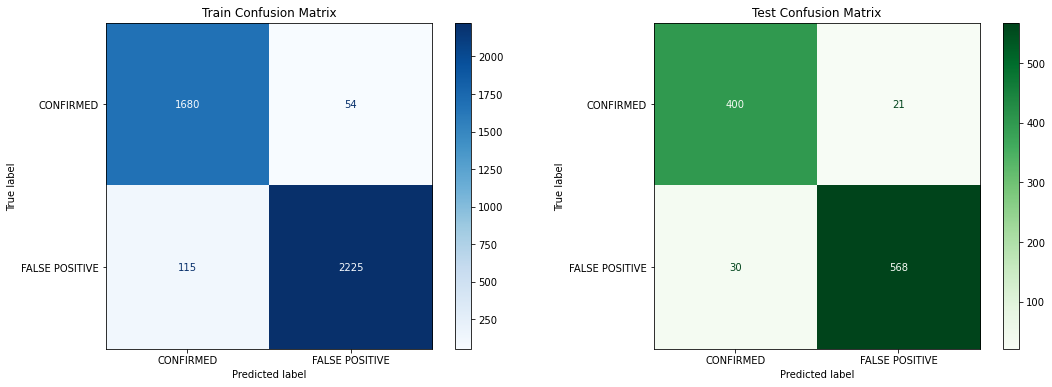

In [39]:
remodel = run_class_model(remodel_pipeline, X_train_r, y_train_r, X_test_r, y_test_r)

### Remodeled Findings

* Model performed worse overall which was expected

# List of models
* Logistic Regression
* K Nearest Neighbors
* Gaussian Naive Bayes
* Random Forest
* ADA Boost
* Gradient Boost
* XG Boost

## Model 1 - Logistic Regression

In [67]:
log_pipe = Pipeline([('ss', StandardScaler()),
                     ('log', LogisticRegression())])
log_grid = [{'log__C': [0,10],
             'log__solver': ['newton-cg','sag','saga','lbfgs','liblinear']}]

In [68]:
log_gridsearch = GridSearchCV(estimator=log_pipe,
                              param_grid=log_grid,
                              scoring='accuracy',
                              cv=5)

********************************************************

     Classification Report: Train

                precision    recall  f1-score   support

     CONFIRMED       0.94      0.97      0.96      1734
FALSE POSITIVE       0.98      0.96      0.97      2340

      accuracy                           0.96      4074
     macro avg       0.96      0.96      0.96      4074
  weighted avg       0.96      0.96      0.96      4074

********************************************************

     Classification Report: Test

                precision    recall  f1-score   support

     CONFIRMED       0.94      0.95      0.95       421
FALSE POSITIVE       0.97      0.96      0.96       598

      accuracy                           0.96      1019
     macro avg       0.95      0.96      0.96      1019
  weighted avg       0.96      0.96      0.96      1019

********************************************************



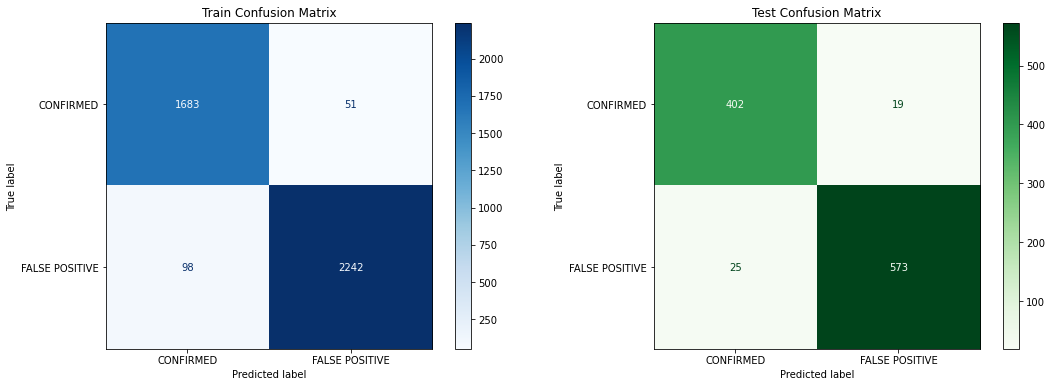

In [69]:
gslog_model = run_class_model(log_gridsearch, X_train_r, y_train_r, X_test_r, y_test_r)

In [44]:
gslog_model.best_params_

{'log__C': 10, 'log__solver': 'newton-cg'}

In [45]:
accuracy_score(y_test_r, gslog_model.predict(X_test_r))

0.9621048497938347

### Logistic Results

* Performs roughly the same as the base log model

## Model 2 - KNN

In [80]:
knn_pipe = Pipeline([('rb', RobustScaler()),#('ss', StandardScaler()),
                     ('knn', KNeighborsClassifier())])
knn_grid = [{'knn__n_neighbors': [2,5],
             'knn__weights' : ['uniform', 'distance'],
             'knn__leaf_size': [30,50]           
            }]

In [81]:
knn_gridsearch = GridSearchCV(estimator=knn_pipe,
                              param_grid=knn_grid,
                              scoring='accuracy',
                              cv=5)

********************************************************

     Classification Report: Train

                precision    recall  f1-score   support

     CONFIRMED       1.00      1.00      1.00      1734
FALSE POSITIVE       1.00      1.00      1.00      2340

      accuracy                           1.00      4074
     macro avg       1.00      1.00      1.00      4074
  weighted avg       1.00      1.00      1.00      4074

********************************************************

     Classification Report: Test

                precision    recall  f1-score   support

     CONFIRMED       0.84      0.98      0.91       421
FALSE POSITIVE       0.98      0.87      0.92       598

      accuracy                           0.92      1019
     macro avg       0.91      0.93      0.92      1019
  weighted avg       0.93      0.92      0.92      1019

********************************************************



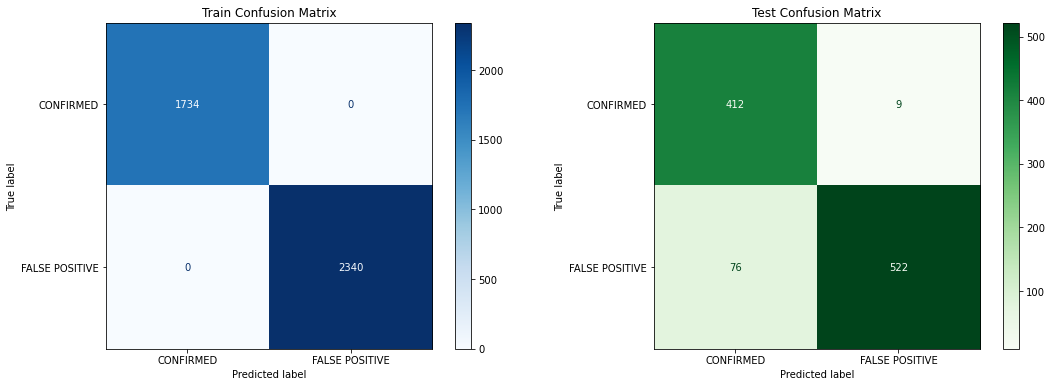

In [82]:
gsknn_model = run_class_model(knn_gridsearch, X_train_r, y_train_r, X_test_r, y_test_r)

In [83]:
gsknn_model.best_params_

{'knn__leaf_size': 30, 'knn__n_neighbors': 5, 'knn__weights': 'distance'}

In [84]:
knn_grid2 = [{'knn__n_neighbors': [2,3],
             'knn__weights' : ['uniform', 'distance'],
             'knn__leaf_size': [40,50]           
            }]

In [85]:
knn_gridsearch2 = GridSearchCV(estimator=knn_pipe,
                              param_grid=knn_grid2,
                              scoring='accuracy',
                              cv=5)

********************************************************

     Classification Report: Train

                precision    recall  f1-score   support

     CONFIRMED       1.00      1.00      1.00      1734
FALSE POSITIVE       1.00      1.00      1.00      2340

      accuracy                           1.00      4074
     macro avg       1.00      1.00      1.00      4074
  weighted avg       1.00      1.00      1.00      4074

********************************************************

     Classification Report: Test

                precision    recall  f1-score   support

     CONFIRMED       0.85      0.97      0.91       421
FALSE POSITIVE       0.98      0.88      0.93       598

      accuracy                           0.92      1019
     macro avg       0.91      0.93      0.92      1019
  weighted avg       0.93      0.92      0.92      1019

********************************************************



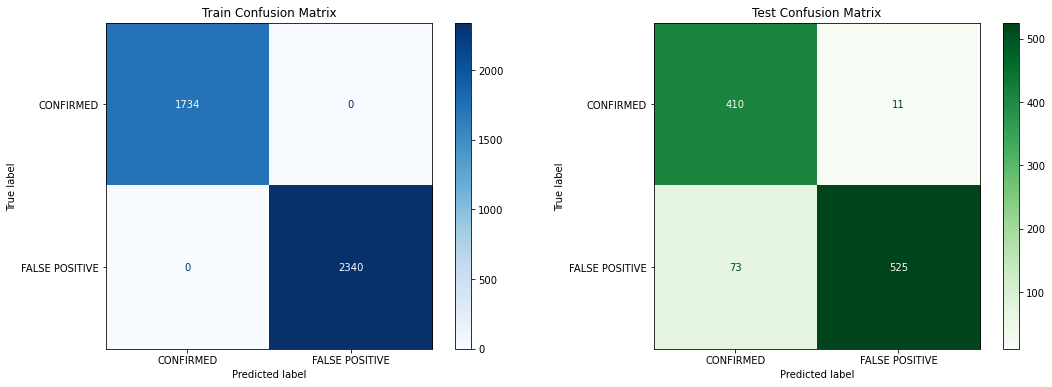

In [86]:
gsknn_model2 = run_class_model(knn_gridsearch2, X_train_r, y_train_r, X_test_r, y_test_r)

In [53]:
gsknn_model2.best_params_

{'knn__leaf_size': 40, 'knn__n_neighbors': 3, 'knn__weights': 'uniform'}

### KNN Results

* Too overfit, test data performs worse than log.
* Reducing overfit does not improve the test performance.

## Gaussian Naive Bayes

********************************************************

     Classification Report: Train

                precision    recall  f1-score   support

     CONFIRMED       0.89      0.97      0.93      1734
FALSE POSITIVE       0.98      0.91      0.94      2340

      accuracy                           0.93      4074
     macro avg       0.93      0.94      0.93      4074
  weighted avg       0.94      0.93      0.93      4074

********************************************************

     Classification Report: Test

                precision    recall  f1-score   support

     CONFIRMED       0.87      0.98      0.92       421
FALSE POSITIVE       0.98      0.90      0.94       598

      accuracy                           0.93      1019
     macro avg       0.93      0.94      0.93      1019
  weighted avg       0.94      0.93      0.93      1019

********************************************************



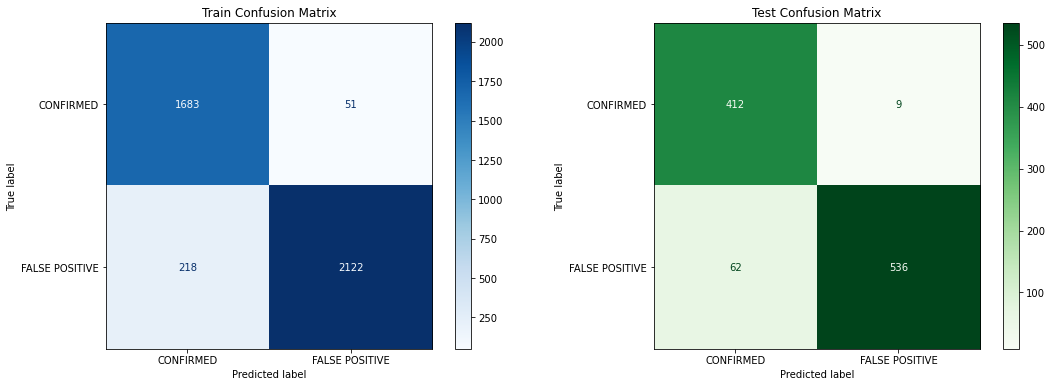

In [88]:
gnb_pipe = Pipeline([('ss', StandardScaler()),
                     ('gnb', GaussianNB())])
gnb_model = run_class_model(gnb_pipe, X_train_r, y_train_r, X_test_r, y_test_r)

### GNB Results

* Performs better than KNN but slightly worse than Logistic

## Random Forest Classifer

In [125]:
rf_pipe = Pipeline([('rb', RobustScaler()),
                    #('ss', StandardScaler()),
                    ('RF', RandomForestClassifier())])
rf_grid = [{'RF__max_depth': [2,9],
            'RF__min_samples_split': [3,6],
            'RF__min_samples_leaf': [3,7],
            'RF__oob_score': [True,False],
           }]

In [126]:
gs_rf = GridSearchCV(estimator = rf_pipe,
                     param_grid = rf_grid,
                     scoring = 'accuracy',
                     cv = 5)

********************************************************

     Classification Report: Train

                precision    recall  f1-score   support

     CONFIRMED       0.97      0.99      0.98      1734
FALSE POSITIVE       0.99      0.98      0.99      2340

      accuracy                           0.98      4074
     macro avg       0.98      0.98      0.98      4074
  weighted avg       0.98      0.98      0.98      4074

********************************************************

     Classification Report: Test

                precision    recall  f1-score   support

     CONFIRMED       0.94      0.98      0.96       421
FALSE POSITIVE       0.98      0.96      0.97       598

      accuracy                           0.97      1019
     macro avg       0.96      0.97      0.96      1019
  weighted avg       0.97      0.97      0.97      1019

********************************************************



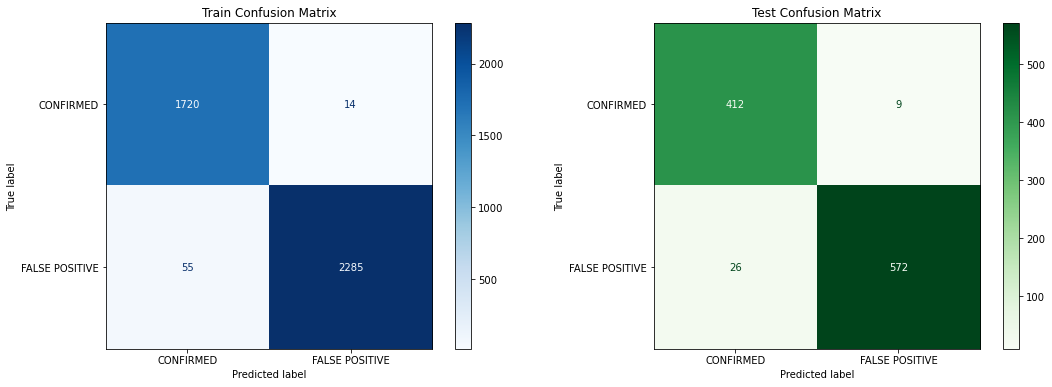

In [127]:
gsrf_model = run_class_model(gs_rf, X_train_r, y_train_r, X_test_r, y_test_r)

In [128]:
gsrf_model.best_params_

{'RF__max_depth': 9,
 'RF__min_samples_leaf': 3,
 'RF__min_samples_split': 6,
 'RF__oob_score': True}

### RF Results

* Performs slightly better than Logistic Regression which was the best model so far.

## ADA Boost

In [141]:
ada_pipe = Pipeline([('rb', RobustScaler()),
                    #('ss', StandardScaler()),
                    ('ada', AdaBoostClassifier())])
ada_grid = [{'ada__learning_rate': [1.5,1.0,.1],
             'ada__n_estimators': [150,100,50,10]
           }]

In [142]:
gs_ada = GridSearchCV(estimator = ada_pipe,
                     param_grid = ada_grid,
                     scoring = 'accuracy',
                     cv = 5)

********************************************************

     Classification Report: Train

                precision    recall  f1-score   support

     CONFIRMED       0.96      0.98      0.97      1734
FALSE POSITIVE       0.99      0.97      0.98      2340

      accuracy                           0.98      4074
     macro avg       0.98      0.98      0.98      4074
  weighted avg       0.98      0.98      0.98      4074

********************************************************

     Classification Report: Test

                precision    recall  f1-score   support

     CONFIRMED       0.95      0.97      0.96       421
FALSE POSITIVE       0.98      0.96      0.97       598

      accuracy                           0.97      1019
     macro avg       0.96      0.97      0.96      1019
  weighted avg       0.97      0.97      0.97      1019

********************************************************



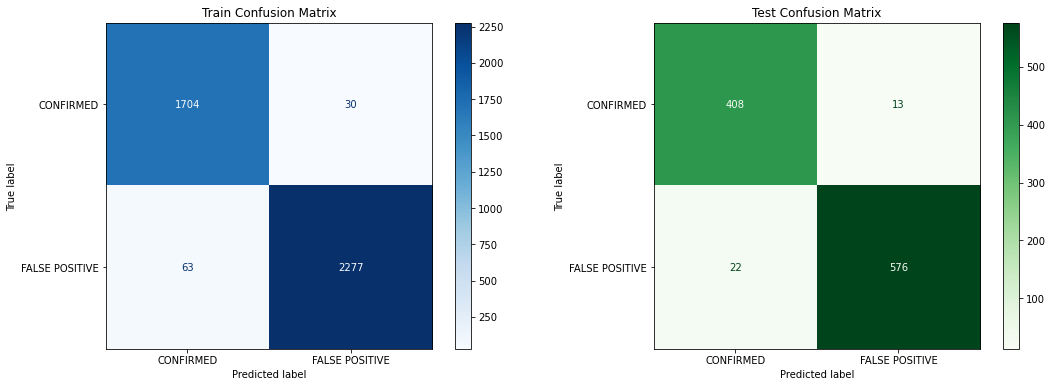

In [143]:
gsada_model = run_class_model(gs_ada, X_train_r, y_train_r, X_test_r, y_test_r)

In [144]:
gsada_model.best_params_

{'ada__learning_rate': 0.1, 'ada__n_estimators': 500}

### ADA Boost Results

## Gradient Boost

In [145]:
gra_pipe = Pipeline([('rb', RobustScaler()),
                    #('ss', StandardScaler()),
                    ('gra', GradientBoostingClassifier())])
gra_grid = [{'gra__learning_rate': [1.5,1.0,.1],
             'gra__n_estimators': [200,100,50,10]
           }]

In [146]:
gs_gra = GridSearchCV(estimator = gra_pipe,
                     param_grid = gra_grid,
                     scoring = 'accuracy',
                     cv = 5)

********************************************************

     Classification Report: Train

                precision    recall  f1-score   support

     CONFIRMED       1.00      1.00      1.00      1734
FALSE POSITIVE       1.00      1.00      1.00      2340

      accuracy                           1.00      4074
     macro avg       1.00      1.00      1.00      4074
  weighted avg       1.00      1.00      1.00      4074

********************************************************

     Classification Report: Test

                precision    recall  f1-score   support

     CONFIRMED       0.96      0.98      0.97       421
FALSE POSITIVE       0.98      0.97      0.98       598

      accuracy                           0.97      1019
     macro avg       0.97      0.97      0.97      1019
  weighted avg       0.97      0.97      0.97      1019

********************************************************



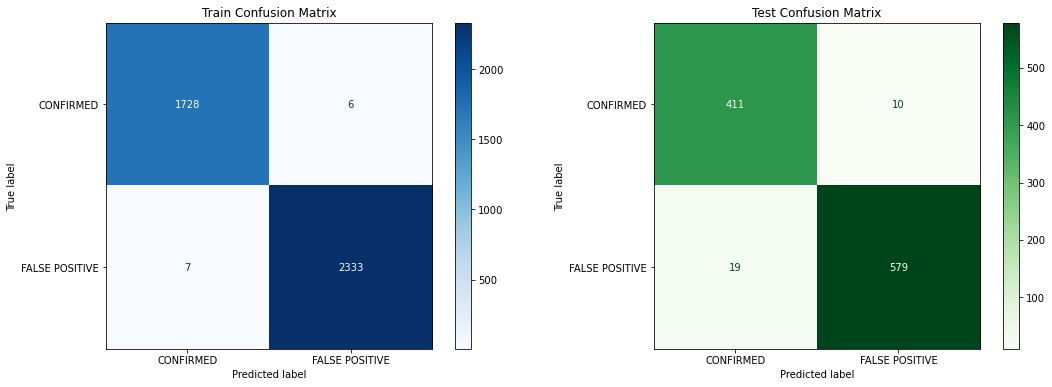

In [147]:
gsgra_model = run_class_model(gs_gra, X_train_r, y_train_r, X_test_r, y_test_r)

In [ ]:
gsgra_model.best_params_

### Gradient Boost Results

## XG Boost

In [150]:
xg_pipe = Pipeline([('rb', RobustScaler()),
                    #('ss', StandardScaler()),
                    ('xg', xgb.XGBClassifier())])
xg_grid = [{'xg__learning_rate': [1.5,1.0,.1],
            'xg__n_estimators': [200,100,50,10]
           }]

In [151]:
gs_xg = GridSearchCV(estimator = xg_pipe,
                     param_grid = xg_grid,
                     scoring = 'accuracy',
                     cv = 5)

********************************************************

     Classification Report: Train

                precision    recall  f1-score   support

     CONFIRMED       1.00      1.00      1.00      1734
FALSE POSITIVE       1.00      1.00      1.00      2340

      accuracy                           1.00      4074
     macro avg       1.00      1.00      1.00      4074
  weighted avg       1.00      1.00      1.00      4074

********************************************************

     Classification Report: Test

                precision    recall  f1-score   support

     CONFIRMED       0.96      0.98      0.97       421
FALSE POSITIVE       0.98      0.97      0.98       598

      accuracy                           0.97      1019
     macro avg       0.97      0.97      0.97      1019
  weighted avg       0.97      0.97      0.97      1019

********************************************************



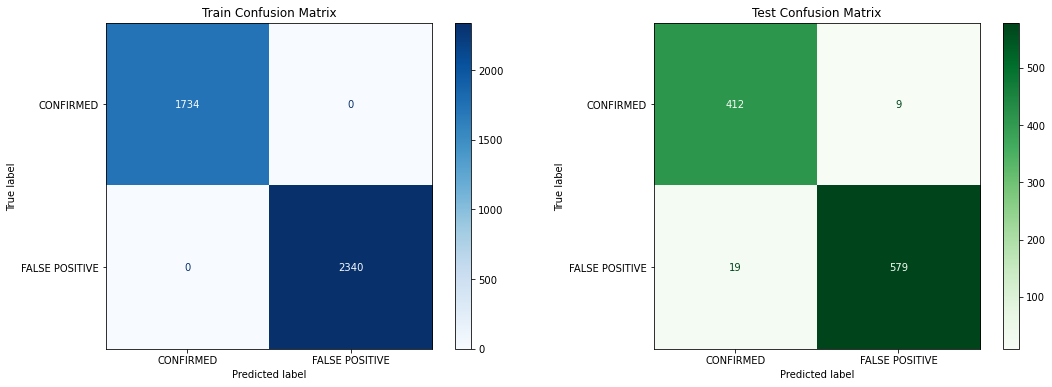

In [152]:
gsxg_model = run_class_model(gs_xg, X_train_r, y_train_r, X_test_r, y_test_r)

In [ ]:
gsxg_model.best_params_

### XG Boost Results

## Support Vector Machines

In [ ]:
svm_pipe = Pipeline([('rb', RobustScaler()),
                    #('ss', StandardScaler()),
                    ('svm', SVC())])
svm_grid = [{'svm__C': [1.5,1.0,.1],
             'svm__kernel': ['linear','poly','rbf','sigmoid'],
           }]

In [ ]:
gs_svm = GridSearchCV(estimator = svm_pipe,
                     param_grid = svm_grid,
                     scoring = 'accuracy',
                     cv = 5)

In [ ]:
gssvm_model = run_class_model(gs_svm, X_train_r, y_train_r, X_test_r, y_test_r)

### SVM Results

## Table of Classification Results

In [ ]:
all_models = [gslog_model,gsknn_model,gnb_model,gsrf_model,gsada_model,gsgra_model,gsxg_model,gssvm_model] #add new model names here
model_names = ['Logistic Regression',
               'K Nearest Neighbors',
               'Gaussian Naive Bayes',
               'Random Forest',
               'ADA Boost',
               'Gradient Boost',
               'XG Boost',
               'Support Vector Machines'
              ]

In [ ]:
for i in range(len(model_names)):
    print(model_names[m],':',accuracy_score(y_test_r, all_models[m].predict(X_test_r)))

In [ ]:
model_table = pd.DataFrame({"Models": model_names,"Accuracy":accuracy_score(y_test_r,all_models.predict(X_test_r))})

### Why the model works best, why were the metrics important

# Rerun Best Model plus reports

# Most important features

## RePlot the distrubutions and relationship with the target variable

# Examples for obtaining feature  importances

In [61]:
# scaled_pipeline2_model[1].feature_importances_

In [62]:
# d = {'Stats':X.columns,'FI':scaled_pipeline2_model[1].feature_importances_}
# d2 = pd.DataFrame(d)

In [63]:
# d2.sort_values(by='FI')